<a href="https://colab.research.google.com/github/JuanIgnaMurua/Grupo-6-ISPC-Proyecto-HotelExplora/blob/main/Predicci%C3%B3n_Hotel_rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wordcloud

In [ ]:
# PASO 1: Importar librerías y configuraciones iniciales
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from wordcloud import WordCloud, STOPWORDS

In [ ]:
# PASO 2: Cargar los datos
data = pd.read_csv('/content/7282_1.csv', engine='python', on_bad_lines='skip')
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [ ]:
# PASO 3: Preprocesar los datos
#Filtrar calificaciones que son 0
data = data[data['reviews.rating']>0]
#Cambiar el nombre de los nombres de las columnas que tienen un '.' en ellos
data = data.rename(index=str, columns={'reviews.date':'reviewsdate', 'reviews.dateAdded':'reviewsdateAdded',
       'reviews.doRecommend':'reviewsdoRecommend', 'reviews.id':'reviewsid', 'reviews.rating':'reviewsrating', 'reviews.text':'reviewstext',
       'reviews.title':'reviewstitle', 'reviews.userCity':'reviewsuserCity', 'reviews.username':'reviewsusername',
       'reviews.userProvince':'reviewsuserProvince'})
data.reviewstext = data.reviewstext.fillna('x')
#Unas pocas centenas de valoraciones tenían una puntuación superior a 5, filtrando estas
data = data[data['reviewsrating']<=5]
#Unas pocas centenas de valoraciones tenían decimales, redondeando cada una de estas hacia abajo a un entero.
data.reviewsrating = data.reviewsrating.astype(int)


In [ ]:
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviewsdate,reviewsdateAdded,reviewsdoRecommend,reviewsid,reviewsrating,reviewstext,reviewstitle,reviewsuserCity,reviewsusername,reviewsuserProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [ ]:
#PASO 4: Crear una función para limpiar las reseñas
#Crearé una función que usaré para limpiar cadenas de reseñas. La función hará lo siguiente con la cadena 'txt': Convertirá la cadena a minúsculas.Eliminará las palabras vacías (stopwords).Encontrará la longitud de la cadena limpia.Extraerá solo los adjetivos. Devolverá una lista con la longitud de la cadena limpia, la cadena limpia y la cadena que contiene solo adjetivos.
def cleanme(txt):
    sent = txt.lower()
    wrds = word_tokenize(sent)
    clwrds = [w for w in wrds if not w in stopwords.words('english')]
    ln = len(clwrds)
    pos = pd.DataFrame(pos_tag(wrds))
    pos = " ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))
    rt = [ln, " ".join(clwrds), pos]
    return(rt)

In [ ]:
# PASO 5: Mostrar los países únicos en los datos
unique_countries = data['country'].unique()

# Muestra la lista de países únicos
print("Unique countries in the dataset:")
for country in unique_countries:
    print(country)

Unique countries in the dataset:
US


In [ ]:
# PASO 6: Visualizar la ubicación de las reseñas de hoteles
plt1 = go.Scatter(x = data.longitude, y=data.latitude, mode = 'markers')
lyt1 = go.Layout(title="Locations of Hotel Reviews", xaxis=dict(title='Longitude'), yaxis=dict(title='Latitude'))
fig1 = go.Figure(data=[plt1], layout=lyt1)
iplot(fig1)

In [ ]:
# PASO 7: Filtrar datos para incluir solo los puntos dentro de los EE.UU.
data = data[((data['latitude']<=50.0) & (data['latitude']>=24.0)) & ((data['longitude']<=-65.0) & (data['longitude']>=-122.0))]

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# PASO 8: Crear un campo que muestre la longitud de cada reseña
tmp = list()
for i in range(len(data)):
    tmp.append(cleanme(data.iloc[i,:]['reviewstext']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

In [ ]:
# PASO 9: Añadir columnas calculadas de nuevo al conjunto de datos
data = data.reset_index()
data = pd.concat([data,tmp], axis=1)
data

,index,address,categories,city,country,latitude,longitude,name,postalCode,province,...,reviewsid,reviewsrating,reviewstext,reviewstitle,reviewsuserCity,reviewsusername,reviewsuserProvince,reviewlen,cleanrev,adjreview
0,60,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,"We had a wonderful, relaxing time. The staff w...",Hospitality at its Best!,Albany,Flo H,NY,36,"wonderful , relaxing time . staff completely a...",wonderful relaxing attentive deluxe available ...
1,61,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,We were in Palm Springs on the day the tempera...,Pure delight!,North Houston,Julie R,TX,37,palm springs day temperature 123 degrees ! des...,palm wonderful little paradise friendly little...
2,62,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,We arrived in Palm Springs not sure what to ex...,Awesome! Quiet secluded tranquility,North Houston,martin n,TX,42,arrived palm springs sure expect .... 's quiet...,sure quiet residential wooden sure spacious we...
3,63,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,This place really is a little paradise!! A bea...,As the title suggests....,Los Angeles,shetravels66,CA,44,place really little paradise ! ! beautiful bou...,little beautiful fresh best comfortable wonder...
4,64,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,Spent 3 nights at Little Paradise boutique hot...,Loved this Wonderful Boutique Hotel!,Los Angeles,Mary Ellen R,CA,45,spent 3 nights little paradise boutique hotel ...,little paradise mother-daughter wonderful rela...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29458,35905,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,We truly enjoyed staying at the Elk Springs re...,We Loved It!,Charlotte,randolphtiffany,NC,40,truly enjoyed staying elk springs resort ! qui...,elk quiet peaceful clean perfect helpful last ...
29459,35906,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,We were here for a 2nd time the last weekend o...,Amazing time (both times!!),Charlotte,Sabrina P,NC,36,2nd time last weekend april ( stayed deer hear...,last first first first second more
29460,35907,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,Best of the Best!!!! My family and I stayed in...,Amazing time (both times!!),Charlotte,Chelsa K.,NC,55,best best ! ! ! ! family stayed grin bear cabi...,best best best perfect gorgeous elk profession...
29461,35908,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,Amazing Vacation in Beautiful Cabin We stayed ...,Amazing time (both times!!),Charlotte,Heather D.,NC,33,amazing vacation beautiful cabin stayed long w...,beautiful long relaxing most nice most nice bu...


In [ ]:
# PASO 10: Visualizar la frecuencia de la longitud de las reseñas
plt2 = go.Histogram(x = data.reviewlen)
lyt2 = go.Layout(title="Frequency of Review Length", xaxis=dict(title='Review Length', range=[0,400]), yaxis=dict(title='Frequency'))
fig2 = go.Figure(data=[plt2], layout=lyt2)
iplot(fig2)

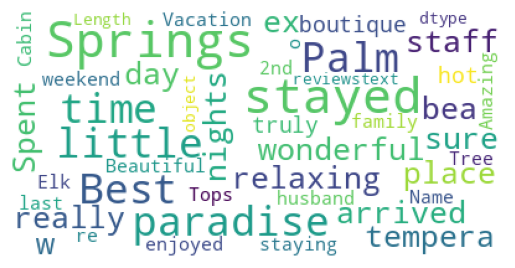

In [ ]:
# PASO 11: Crear y mostrar una nube de palabras
mpl.rcParams['font.size']=12                #10
mpl.rcParams['savefig.dpi']=100             #72
mpl.rcParams['figure.subplot.bottom']=.1
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=STOPWORDS,
    max_words=200,
    max_font_size=40,
    random_state=42
).generate(str(data['reviewstext']))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# PASO 12: Visualizar la longitud de las reseñas frente a la calificación
data = data.sort_values(by='reviewlen')
plt3 = go.Scatter(x = data.reviewlen, y = data.reviewsrating, mode='markers')
lyt3 = go.Layout(title="Review Length vs. Star Rating", xaxis=dict(title='Review Length'),yaxis=dict(title='Rating'))
fig3 = go.Figure(data=[plt3], layout=lyt3)
iplot(fig3)
print("Review Length to Rating Correlation:",data.reviewlen.corr(data.reviewsrating))

Review Length to Rating Correlation: -0.1605662318320769


In [ ]:
# PASO 13: Configurar los datos X e Y para los modelos de machine learning
#Setting up the X and Y data, where X is the review text and Y is the rating
#Three different inputs will be used: original review text, cleaned review text, and only adjectives review text
x1 = data.reviewstext
x2 = data.cleanrev
x3 = data.adjreview
y = data.reviewsrating

In [ ]:
# PASO 14: Crear un vectorizador para dividir el texto en unigrams y bigrams
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(x1)
x_vect2 = vect.fit_transform(x2)
x_vect3 = vect.fit_transform(x3)

In [ ]:
# PASO 15: Definir funciones para Linear SVC, KNN y Naive Bayes
def entrenar_linsvc(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = LinearSVC(dual=False)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("Linear SVC Accuracy:", accuracy)
    return classf, accuracy

def entrenar_knn(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = KNeighborsClassifier(n_neighbors=2)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("KNN Accuracy:", accuracy)
    return classf, accuracy

def entrenar_naive_bayes(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = MultinomialNB()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("Naive Bayes Accuracy:", accuracy)
    return classf, accuracy

In [ ]:
# PASO 16: Entrenar y evaluar los modelos
svm_model, svm_accuracy = entrenar_linsvc(x_vect2, y)
knn_model, knn_accuracy = entrenar_knn(x_vect2, y)
nb_model, nb_accuracy = entrenar_naive_bayes(x_vect2, y)

# Comparamos las precisiones
print("Linear SVC Accuracy:", svm_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)

Linear SVC Accuracy: 0.5176486559869672
KNN Accuracy: 0.18083084442030953
Naive Bayes Accuracy: 0.41039913114308985
Linear SVC Accuracy: 0.5176486559869672
KNN Accuracy: 0.18083084442030953
Naive Bayes Accuracy: 0.41039913114308985


In [ ]:
# Crear y mostrar una matriz de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
  Esta función imprime y traza la matriz de confusión.
 La normalización se puede aplicar configurando `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]),decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2562   94   88   64   92]
 [ 170 2074  210  141   87]
 [  91   87 3916  444  369]
 [  53   46  252 6733 1099]
 [  28   25  106  649 9983]]
Confusion matrix, without normalization
[[2221    5  671    1    2]
 [  25 2002  645    5    5]
 [  24   39 4814   15   15]
 [  33   43 7473  584   50]
 [  30   38 9722  344  657]]
Confusion matrix, without normalization
[[  475     0    37   496  1892]
 [   13    26    76   882  1685]
 [    5     0   651  1050  3201]
 [    3     0    11  3709  4460]
 [    2     0     6   104 10679]]


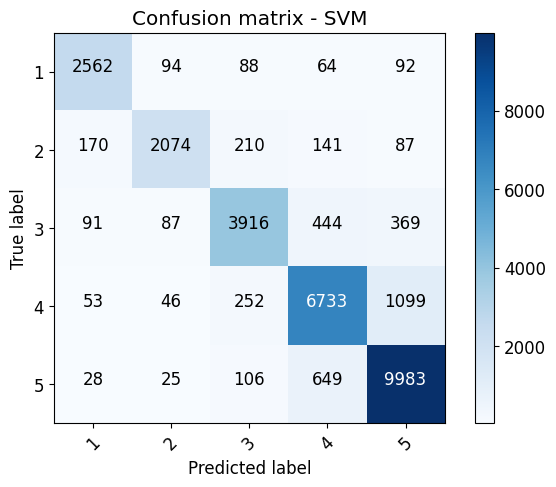

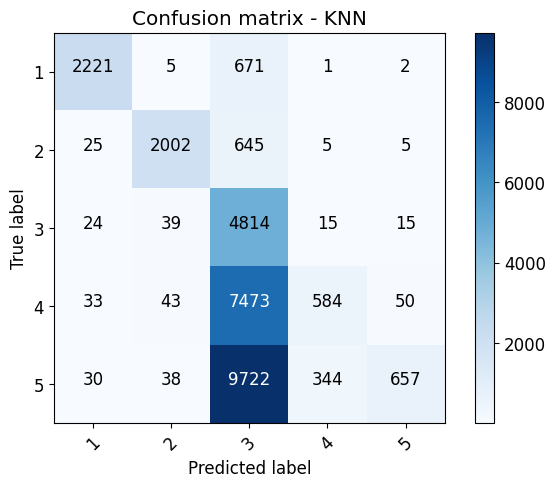

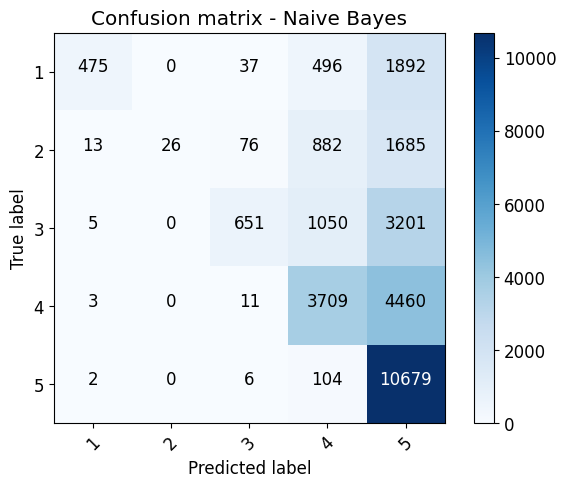

In [ ]:
# Generar y graficar las matrices de confusión
c1 = confusion_matrix(y, svm_model.predict(x_vect2))
c2 = confusion_matrix(y, knn_model.predict(x_vect2))
c3 = confusion_matrix(y, nb_model.predict(x_vect2))
class_names = ['1', '2', '3', '4', '5']
plt.figure()
plot_confusion_matrix(c1, classes=class_names, normalize=False, title='Confusion matrix - SVM')
plt.figure()
plot_confusion_matrix(c2, classes=class_names, normalize=False, title='Confusion matrix - KNN')
plt.figure()
plot_confusion_matrix(c3, classes=class_names, normalize=False, title='Confusion matrix - Naive Bayes')
plt.show()


In [ ]:
print(data.columns)

Index(['index', 'address', 'categories', 'city', 'country', 'latitude',
       'longitude', 'name', 'postalCode', 'province', 'reviewsdate',
       'reviewsdateAdded', 'reviewsdoRecommend', 'reviewsid', 'reviewsrating',
       'reviewstext', 'reviewstitle', 'reviewsuserCity', 'reviewsusername',
       'reviewsuserProvince', 'reviewlen', 'cleanrev', 'adjreview'],
      dtype='object')


In [ ]:
city_list = data['city'].tolist()

In [ ]:
print(city_list)

['Cheyenne', 'Biloxi', 'Palm Harbor', 'Long Beach', 'Palm Harbor', 'Palm Harbor', 'Atlantic Beach', 'Atlantic Beach', 'Pittsburgh', 'Edinburg', 'Cedar Rapids', 'Las Vegas', 'Las Vegas', 'Branson', 'Morro Bay', 'Bellmawr', 'Warren', 'Metropolis', 'Shreveport', 'Ruther Glen', 'Palm Harbor', 'Chantilly', 'Chantilly', 'Warner Robins', 'West Memphis', 'Midvale', 'Mount Arlington', 'Marina', 'Chinle', 'Virginia Beach', 'Livermore', 'Marina', 'Indianapolis', 'Florence', 'Morro Bay', 'Austin', 'Alexandria', 'Vinita', 'Newburgh', 'Big Rapids', 'Manhattan', 'Lake Forest', 'Newburgh', 'Newburgh', 'Newburgh', 'Sulphur', 'San Antonio', 'Austin', 'Las Vegas', 'Abilene', 'West Deptford', 'Plainville', 'West Memphis', 'Fort Lauderdale', 'Garden Grove', 'Montgomery', 'Grand Rapids', 'Coralville', 'Virginia Beach', 'Troy', 'Boone', 'Boone', 'Troy', 'Laughlin', 'Virginia Beach', 'Branson', 'Colorado Springs', 'Columbus', 'Laughlin', 'Slidell', 'Huntingdon', 'Jacksonville', 'Newburgh', 'Springfield', 'Rut

Este código define una función hotel_recommendation_by_city_rating que recomienda hoteles en una ciudad dada con una clasificación dentro de un rango específico. Filtra los datos según la ciudad y el rango de clasificación, luego calcula el promedio de clasificación para cada hotel y devuelve las tres mejores recomendaciones.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Descargar los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# Función para limpiar las reseñas
def cleanme(txt):
    sent = txt.lower()
    wrds = word_tokenize(sent)
    clwrds = [w for w in wrds if not w in stopwords.words('english')]
    ln = len(clwrds)
    pos = pd.DataFrame(pos_tag(wrds))
    pos = " ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))
    rt = [ln, " ".join(clwrds), pos]
    return(rt)

# Función para recomendación de hoteles por rating y ciudad
def try_convert_to_numeric(value):
    try:
        return float(value)
    except (TypeError, ValueError):
        return None

def hotel_recommendation_by_city_rating(city, rating, data):
    # Filtrar los datos para la ciudad específica
    city_data = data[data['city'] == city]

    # Filtrar por rating dentro de un rango más amplio
    similar_hotels = city_data[(city_data['reviewsrating'] >= rating - 1) & (city_data['reviewsrating'] <= rating + 1)]

    # Convertir la columna 'reviewsrating' a tipo numérico
    similar_hotels['reviewsrating'] = similar_hotels['reviewsrating'].apply(try_convert_to_numeric)

    # Eliminar filas con valores no numéricos en la columna 'reviewsrating'
    similar_hotels = similar_hotels.dropna(subset=['reviewsrating'])

    # Agrupar por nombre y dirección del hotel y calcular el promedio del rating
    similar_hotels_grouped = similar_hotels.groupby(['name', 'address'])['reviewsrating'].mean().reset_index()

    # Ordenar por rating en orden descendente
    top_recommendations = similar_hotels_grouped.sort_values(by='reviewsrating', ascending=False).head(3)

    return top_recommendations


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Ejemplo de uso 1:
city ='New York'
rating = 5
recommendations = hotel_recommendation_by_city_rating(city, rating, data)
print(recommendations)

                                      name        address  reviewsrating
0            Best Western Plus-seaport Inn        33 Peck            5.0
2  Holiday Inn Manhattan 6th Ave - Chelsea  125 W 26th St            5.0
3                             Hotel Olcott   27 W 72nd St            5.0


<ipython-input-10-5f76f2e09cfd>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Ejemplo de uso 2:
city ='Houston'
rating = 5
recommendations = hotel_recommendation_by_city_rating(city, rating, data)
print(recommendations)

                                        name            address  reviewsrating
1  Embassy Suites By Hilton Houston Downtown     1515 Dallas St       5.000000
3                      La Quinta Inn-houston    930 Normandy St       5.000000
5                       The Houstonian Hotel  111 N Post Oak Ln       4.830508


<ipython-input-10-5f76f2e09cfd>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

